# **APLICACION DE REDES NEURONALES PARA LA CLASIFICACION Y DETECCION DE TUMORES CEREBRALES CON IMAGENES DE RESONANCIA MAGNETICA**


In [2]:
!pip install kagglehub
!pip install tensorflow

### **LITERATURA:**
- Glioma: Tumor en las celular gliales. puede ser agresivo y potencialmente mortales. Dependiendo de su tipo y grado.Los gliomas de alto grado son más peligrosos y pueden crecer rápidamente, mientras que los de bajo grado suelen ser más lentos y pueden ser tratados más efectivamente.

- Meningioma: Tumor en las meninges, generalmente benigno, aunque puede causar problemas neurologico que incluyen convulsiones, problemas visuales y dolores de cabeza

- Sin tumor: Ausencia de tumores

- Pituitaria: Glandula que regula funciones hormonales, con posibles tumores denominados adenomas, que son en su mayoría benignos. Pueden causar complicaciones graves si crecen y presionan estructuras cerebrales adyacentes interfiriendo en el equilibrio hormonal y causar diversos problemas de salud como crecimiento(enanismo o gigantismo), mestruales u otros desbalances hormonales.

In [3]:
#Carga de datos
import os
import kagglehub
#Eda
import pandas as pd
import numpy as np
#Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
#Preproceso
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
#Preprocesar imagenes
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#modelo
from tensorflow import keras
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras import layers, Input
from keras.layers import InputLayer, MaxPooling2D, Flatten, Dense, Conv2D, Dropout
from keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, SGD

#Metricas de evaluacion
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score,RocCurveDisplay, auc,classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

2024-10-18 15:01:13.995089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 15:01:16.978620: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2024-10-18 15:01:16.978843: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local

### **1. CARGAR DATOS A TRAVES DE API KAGGLE**

In [4]:
#Descaragar version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Nombre de las carpetas", os.listdir(path))

Nombre de las carpetas ['Testing', 'Training']


In [5]:
#listar carpetas
entrenamiento = os.path.join(path, 'Training')
prueba = os.path.join(path, 'Testing')
# Comprobar las carpetas
print('Lista de entrenamiento',os.listdir(entrenamiento))
print('Lista de prueba',os.listdir(prueba))

Lista de entrenamiento ['pituitary', 'glioma', 'meningioma', 'notumor']
Lista de prueba ['pituitary', 'glioma', 'meningioma', 'notumor']


In [6]:
#Crear un df para las imagenes
def df_nuevo(directory):
  data=[]
  for etiqueta in os.listdir(directory):
    etiqueta_path = os.path.join(directory, etiqueta)
    for imagenes in os.listdir(etiqueta_path):
      imagen_patch =os.path.join(etiqueta_path, imagenes)
      data.append((imagen_patch, etiqueta))

  return pd.DataFrame(data, columns=['Imagenes', 'Etiqueta'])

train_df = df_nuevo(entrenamiento)
test_df = df_nuevo(prueba)
print(train_df)
print(test_df)

                                               Imagenes   Etiqueta
0     /home/jupyter/.cache/kagglehub/datasets/masoud...  pituitary
1     /home/jupyter/.cache/kagglehub/datasets/masoud...  pituitary
2     /home/jupyter/.cache/kagglehub/datasets/masoud...  pituitary
3     /home/jupyter/.cache/kagglehub/datasets/masoud...  pituitary
4     /home/jupyter/.cache/kagglehub/datasets/masoud...  pituitary
...                                                 ...        ...
5707  /home/jupyter/.cache/kagglehub/datasets/masoud...    notumor
5708  /home/jupyter/.cache/kagglehub/datasets/masoud...    notumor
5709  /home/jupyter/.cache/kagglehub/datasets/masoud...    notumor
5710  /home/jupyter/.cache/kagglehub/datasets/masoud...    notumor
5711  /home/jupyter/.cache/kagglehub/datasets/masoud...    notumor

[5712 rows x 2 columns]
                                               Imagenes   Etiqueta
0     /home/jupyter/.cache/kagglehub/datasets/masoud...  pituitary
1     /home/jupyter/.cache/kagglehub/

### **2. EXPLORACION Y ANALISIS DE DATOS**

/var/tmp/ipykernel_4490/155805188.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Etiqueta', fontsize=10)
/var/tmp/ipykernel_4490/155805188.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Etiqueta', fontsize=10)


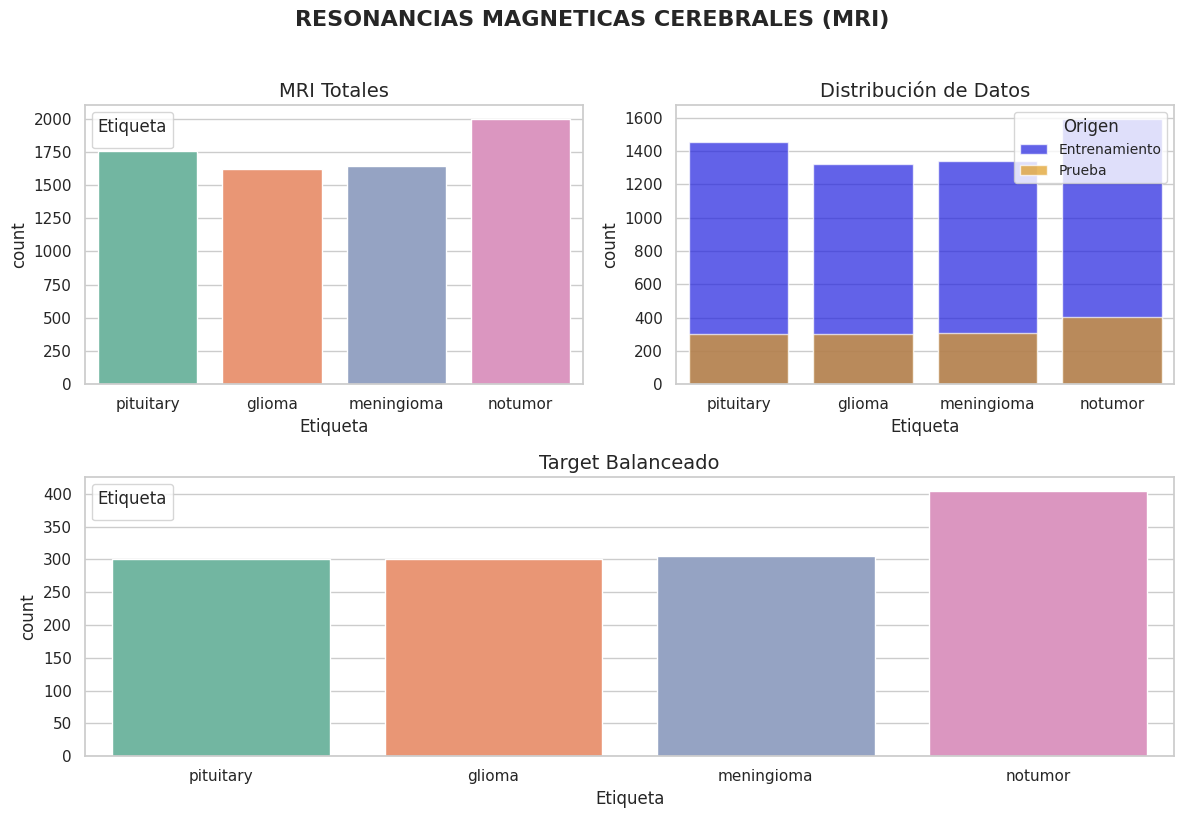

DATOS ORGINALES, total: 7023 
      Etiqueta  Conteo Porcentaje
0     notumor    2000      28.0%
1   pituitary    1757      25.0%
2  meningioma    1645      23.0%
3      glioma    1621      23.0%

DISTRIBUCION DE DATOS ENTRENAMIENTO, total: 5712 
               Etiqueta  Conteo Porcentaje
Etiqueta                                 
notumor        notumor    1595      28.0%
pituitary    pituitary    1457      26.0%
meningioma  meningioma    1339      23.0%
glioma          glioma    1321      23.0%

DISTRIBUCION DE DATOS PRUEBA, total: 1311 = 18.67 %
               Etiqueta  Conteo Porcentaje
Etiqueta                                 
notumor        notumor     405      31.0%
meningioma  meningioma     306      23.0%
pituitary    pituitary     300      23.0%
glioma          glioma     300      23.0%


In [7]:
#Crear un df uniendo todos los datos
df_total = pd.concat([train_df, test_df], ignore_index=True)

#Graficar distribucion de datos
sns.set(style="whitegrid")
plt.figure(dpi=100, figsize=(12,8))
plt.suptitle('RESONANCIAS MAGNETICAS CEREBRALES (MRI)', fontsize=16, fontweight='bold', y=1.02)

#Datos totales
plt.subplot(2, 2, 1)
plt.title('MRI Totales', fontsize=14)
sns.countplot(data=df_total, x='Etiqueta', hue='Etiqueta', palette='Set2')
plt.legend(title='Etiqueta', fontsize=10)

#Distribucion de train y test
plt.subplot(2, 2, 2)
plt.title('Distribución de Datos', fontsize=14)
sns.countplot(data=train_df, x='Etiqueta', color='blue', alpha=0.7, label='Entrenamiento')
sns.countplot(data=test_df, x='Etiqueta', color='orange', alpha=0.7, label='Prueba')
plt.legend(title='Origen', fontsize=10)

#Grafico de la distribucion del target
plt.subplot(2, 2, (3, 4))
plt.title('Target Balanceado', fontsize=14)
sns.countplot(data=test_df, x='Etiqueta', hue='Etiqueta', palette='Set2')
plt.legend(title='Etiqueta', fontsize=10)

plt.savefig('Distribucion de datos.png')
plt.tight_layout()
plt.show()

#=================================================================================================
#TABLAS DE RESULTADOS

#Df total
conteo = df_total['Etiqueta'].value_counts()
por_total = round((conteo/conteo.sum())*100)
por_total = por_total.astype(str) + '%'
df_total_porcentaje = pd.DataFrame({'Etiqueta':conteo.index, 'Conteo':conteo.values, 'Porcentaje':por_total.values})
print('DATOS ORGINALES, total:', conteo.sum(),'\n',df_total_porcentaje)


# Distribución de datos entrenamiento
conteo_datos = train_df['Etiqueta'].value_counts()
por_datos = (conteo_datos / conteo_datos.sum() * 100).round()
df_datos_porcentaje = pd.DataFrame({
    'Etiqueta': conteo_datos.index,
    'Conteo': conteo_datos.values,
    'Porcentaje': (por_datos.astype(str) + '%')  # Asegurarse de que los porcentajes son cadenas
})
print('\nDISTRIBUCION DE DATOS ENTRENAMIENTO, total:', conteo_datos.sum(), '\n', df_datos_porcentaje)


# Distribución de datos prueba
conteo_test = test_df['Etiqueta'].value_counts()
por_test = round((conteo_test / conteo_test.sum()) * 100)
df_test_porcentaje = pd.DataFrame({
    'Etiqueta': conteo_test.index,
    'Conteo': conteo_test.values,
    'Porcentaje': (por_test.astype(str) + '%')  # Asegurarse de que los porcentajes son cadenas
})
print('\nDISTRIBUCION DE DATOS PRUEBA, total:', conteo_test.sum(), '=', round((conteo_test.sum()/conteo.sum()*100), 2), '%\n', df_test_porcentaje)

### **3. PREPROCESAMIENTO DE IMAGENES**

In [8]:
#Dividir data
X_train = train_df['Imagenes']
X_test = test_df['Imagenes']
y_train = train_df['Etiqueta']
y_test = test_df['Etiqueta']

alto = 224
ancho = 224
# Se procesan las imágenes para convertirlas en arrays que contienen la información de los pixels
#Escalar
X_train_scaler = X_train.map(lambda x: np.asarray(Image.open(x).resize((alto, ancho))))
X_train_scaler = X_train_scaler.apply(lambda x: x.astype('float32') / 255.0)
X_test_scaler = X_test.map(lambda x: np.asarray(Image.open(x).resize((alto, ancho))))
X_test_scaler = X_test_scaler.apply(lambda x: x.astype('float32') / 255.0)
#ONE HOT ECODING
encoder = OneHotEncoder(sparse_output=False)
y_train_one = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_one = encoder.transform(y_test.values.reshape(-1, 1))

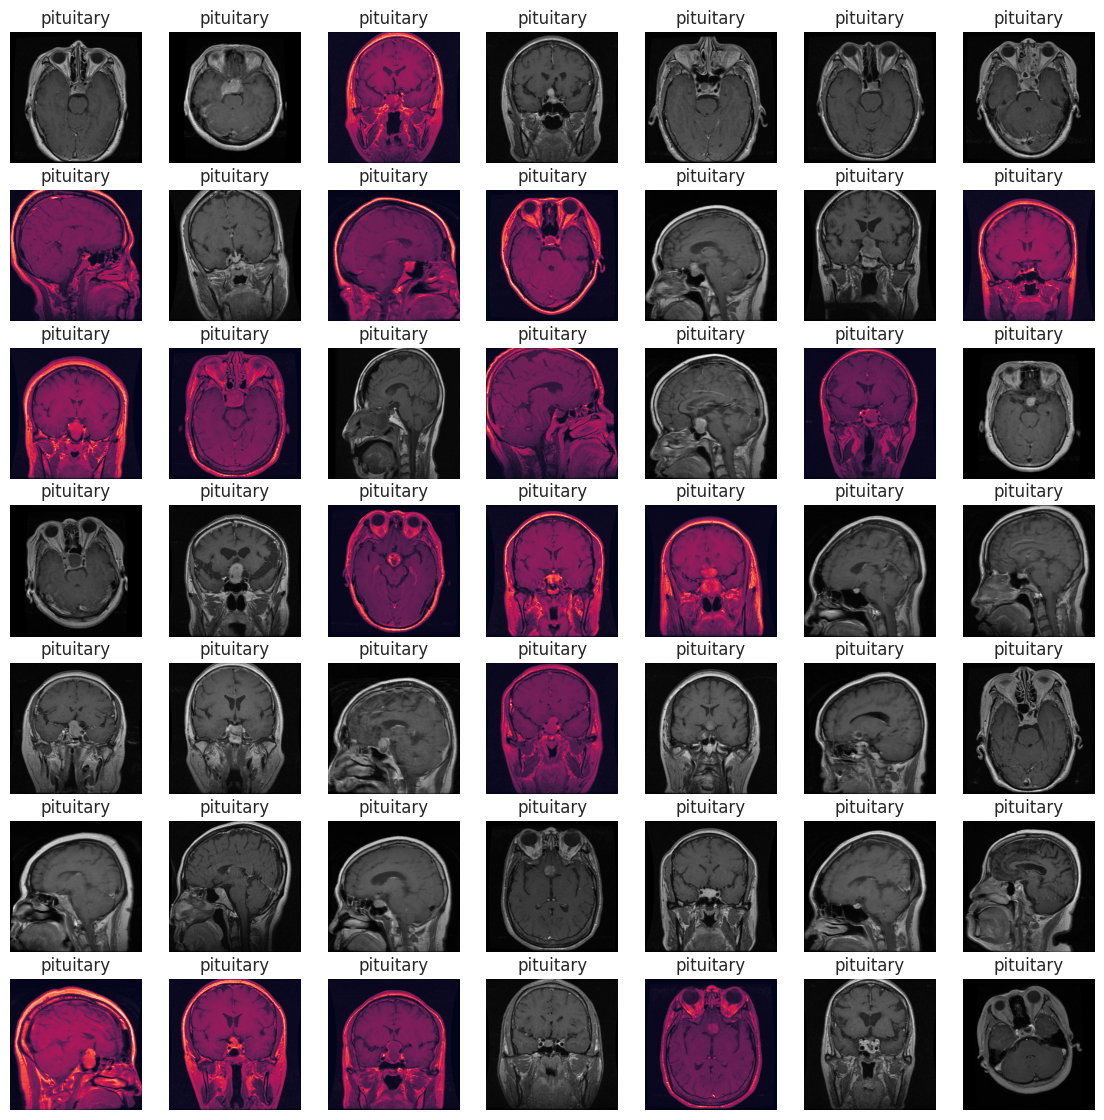

In [9]:
#GRAFICAR IMAGEN
plt.figure(figsize=(14, 14))
for i in range(49):
    # Mostrar cada imagen en su subgrafico correspondiente
  plt.subplot(7, 7, i + 1)
  plt.imshow(X_train_scaler.iloc[i])  # Mostrar la imagen
  plt.title(f"{y_train.iloc[i]}")
  plt.axis('off')  # Sin ejes para las imágenes
plt.savefig('radiografias.png')
plt.show()

### **4. INGENIERIA DE CARACTERISTICAS**

El dataset actual tiene un total de 7023 imagenes.
Un ser humano puede reconocer a simple una misma imagen de radiografia inclinada, pero un modelo de machile learning no lo puede ser, por ese se aumentara el dataset rotando imagenes.

In [10]:
#Funcion para aumentar imagenes con rotaciones en el dataset
def imagenes_aumentadas(X,y):
    X_aumentado = []
    y_aumentado = []

    for img_scal, label in zip(X,y):
        #Existe imagenes a color(3d) y grises(2d).Se convierte todo a e 3canales
        if img_scal.ndim == 2: #Imagenes 2d
            img_scal = np.stack([img_scal] * 3, axis=-1)
        # Si la imagen tiene 4 canales (RGBA), se eliminara el canal alfa
        if img_scal.shape[-1] == 4:  # Imagenes con canal alfa
            img_scal = img_scal[:, :, :3] #los 3 primeros canales dejando el alfa fuera
            
        #Guardar imagen original ya escalada
        X_aumentado.append(img_scal)
        y_aumentado.append(label)
    
        #Convertir las imagenes escaladas a imagen para rotar
        img_nueva = Image.fromarray((img_scal * 255).astype('uint8'))
    
        #Se probara rotando la imagen 30,  90, 180 y 270 grados
        for rotacion in [30,90,180,270]:
            img_rotada = img_nueva.rotate(rotacion)
            rotacion_np = np.array(img_rotada).astype('float32') / 255.0 #Escalar nuevamente  
            #Existe imagenes a color(3d) y grises(2d).Se convierte todo a e 3canales
            if len(rotacion_np.shape) == 2:
                rotacion_np = np.stack([rotacion_np] * 3, axis=-1)
            X_aumentado.append(rotacion_np)
            y_aumentado.append(label)
        
    return np.array(X_aumentado), np.array(y_aumentado)

#Aumentar dataset con las rotaciones
X_train_rotar, y_train_rotar = imagenes_aumentadas(X_train_scaler, y_train_one)
X_test_rotar, y_test_rotar = imagenes_aumentadas(X_test_scaler, y_test_one)

#Convierto los valores a formato unidimensional para poder trabajar con categorical
y_train_rotar = np.argmax(y_train_rotar, axis=1)
y_test_rotar = np.argmax(y_test_rotar, axis=1)
#Se aplica to_categorical y no onehotencoding ya que este ultimo me devuelve una matriz dispersa, lo cual no sera 
#ideal para trabajar con mi modelo de red neuronal
y_train_one = to_categorical(y_train_rotar)
y_test_one = to_categorical(y_test_rotar)

#Verificar tamaño de mi nuevo dataset
print('Tamaño final de X_train', X_train_rotar.shape)
print('Tamaño final de y_train', y_train_one.shape)
print('Tamaño final de X_test', X_test_rotar.shape)
print('Tamaño final de y_test', y_test_one.shape)

Tamaño final de X_train (28560, 224, 224, 3)
Tamaño final de y_train (28560, 4)
Tamaño final de X_test (6555, 224, 224, 3)
Tamaño final de y_test (6555, 4)


In [11]:
#Nueva distribucion de valores
#Df total
conteo = df_total['Etiqueta'].value_counts()*5
por_total = round((conteo/conteo.sum())*100)
por_total = por_total.astype(str) + '%'
df_total_porcentaje = pd.DataFrame({'Etiqueta':conteo.index, 'Conteo':conteo.values, 'Porcentaje':por_total.values})
print('DATOS ORGINALES, total:', conteo.sum(),'\n',df_total_porcentaje)


# Distribución de datos entrenamiento
conteo_datos = train_df['Etiqueta'].value_counts()*5
por_datos = (conteo_datos / conteo_datos.sum() * 100).round()
df_datos_porcentaje = pd.DataFrame({
    'Etiqueta': conteo_datos.index,
    'Conteo': conteo_datos.values,
    'Porcentaje': (por_datos.astype(str) + '%')  # Asegurarse de que los porcentajes son cadenas
})
print('\nDISTRIBUCION DE DATOS ENTRENAMIENTO, total:', conteo_datos.sum(), '\n', df_datos_porcentaje)


# Distribución de datos prueba
conteo_test = test_df['Etiqueta'].value_counts()*5
por_test = (conteo_test / conteo_test.sum() * 100).round()
df_test_porcentaje = pd.DataFrame({
    'Etiqueta': conteo_test.index,
    'Conteo': conteo_test.values,
    'Porcentaje': (por_test.astype(str) + '%')  # Asegurarse de que los porcentajes son cadenas
})
print('\nDISTRIBUCION DE DATOS PRUEBA, total:', conteo_test.sum(),'=', round((conteo_test.sum()/conteo.sum())*100),'%\n', df_test_porcentaje)

DATOS ORGINALES, total: 35115 
      Etiqueta  Conteo Porcentaje
0     notumor   10000      28.0%
1   pituitary    8785      25.0%
2  meningioma    8225      23.0%
3      glioma    8105      23.0%

DISTRIBUCION DE DATOS ENTRENAMIENTO, total: 28560 
               Etiqueta  Conteo Porcentaje
Etiqueta                                 
notumor        notumor    7975      28.0%
pituitary    pituitary    7285      26.0%
meningioma  meningioma    6695      23.0%
glioma          glioma    6605      23.0%

DISTRIBUCION DE DATOS PRUEBA, total: 6555 = 19 %
               Etiqueta  Conteo Porcentaje
Etiqueta                                 
notumor        notumor    2025      31.0%
meningioma  meningioma    1530      23.0%
pituitary    pituitary    1500      23.0%
glioma          glioma    1500      23.0%


Se agrego 4 tipos diferentes de grados para rotar la imagen(30,  90, 180 y 270 grados). A la cantidad original de imagenes se le aumento 4 veces la misma cantidad.
Se observa el aumento de imagenes de la cantidad inicial x 5.

### **5. CREAR MODELO**

In [25]:
#Se crea una red neuronal Convolucionales(CNN)
modelo = Sequential([
    #1ra capa
    Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu', input_shape=(224, 224, 3)),
    
    #2da capa, se agrega  kernel_regularizer L1 para agregar regularización y prevenir el sobreajuste, penalizando los valores de los pesos.
    Conv2D(16, kernel_size=3, strides=(3, 3), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l1(0.01)),
    MaxPooling2D((2,2)),

    #capa oculta
    Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l1(0.01)),
    Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l1(0.01)),
    MaxPooling2D((2,2)),

    #capa oculta
    Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l1(0.01)),
    Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l1(0.01)),
    MaxPooling2D((2,2)),

    #Aplanamiento 
    Flatten(),
    #Capa de salida
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

#Compilar el modelo
modelo.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


#Entrenar el modelo
history = modelo.fit(X_train_rotar, y_train_one, epochs=100, batch_size=256, validation_split=0.2)

Epoch 1/100


2024-10-18 20:19:34.247170: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 13757054976 exceeds 10% of free system memory.


90/90 [==============================] - 118s 1s/step - loss: 22.8276 - accuracy: 0.5923 - val_loss: 10.2294 - val_accuracy: 0.2379
Epoch 2/100
90/90 [==============================] - 103s 1s/step - loss: 4.6102 - accuracy: 0.6758 - val_loss: 2.8405 - val_accuracy: 0.5203
Epoch 3/100
90/90 [==============================] - 104s 1s/step - loss: 1.8592 - accuracy: 0.6909 - val_loss: 2.0770 - val_accuracy: 0.5361
Epoch 4/100
90/90 [==============================] - 104s 1s/step - loss: 1.4157 - accuracy: 0.7054 - val_loss: 2.6542 - val_accuracy: 0.2705
Epoch 5/100
90/90 [==============================] - 103s 1s/step - loss: 1.2653 - accuracy: 0.7055 - val_loss: 1.4058 - val_accuracy: 0.6443
Epoch 6/100
90/90 [==============================] - 104s 1s/step - loss: 1.1470 - accuracy: 0.7149 - val_loss: 1.6458 - val_accuracy: 0.5184
Epoch 7/100
90/90 [==============================] - 104s 1s/step - loss: 1.0564 - accuracy: 0.7285 - val_loss: 1.5308 - val_accuracy: 0.5833
Epoch 8/100
90/9

### **6. EVALUACION DE VALIDACION - SOBREAJUSTE**

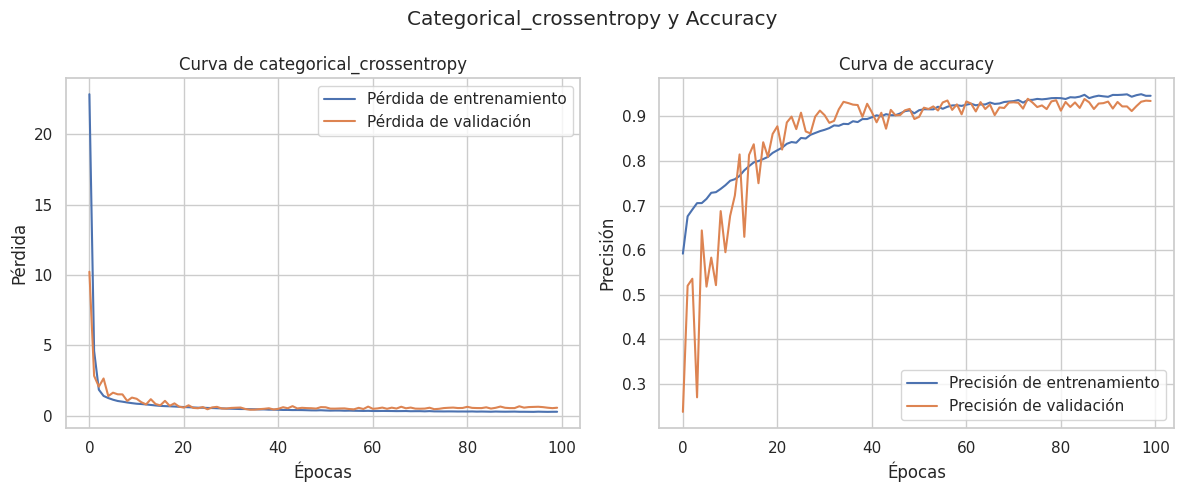

In [26]:
#GRAFICAR RESULTADOS
plt.figure(dpi=100, figsize=(12,5))
plt.suptitle('Categorical_crossentropy y Accuracy')
#PERDIDA
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de categorical_crossentropy')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.grid(True)
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Curva de accuracy')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.savefig('Validacion_error.png')
plt.tight_layout()
plt.show()

In [27]:
loss, accuracy = modelo.evaluate(X_test_rotar,y_test_one)
print('Perdida del conjunto de prueba:', loss)
print('Presicion del conjunto de prueba:', round(accuracy*100), '%')

205/205 [==============================] - 8s 41ms/step - loss: 0.4608 - accuracy: 0.9176
Perdida del conjunto de prueba: 0.460809588432312
Presicion del conjunto de prueba: 92 %


Perdida = 0.24.
Se observa una perdida inicial muy alta loss: 22.8946, indica que al principio el modelo estaba alejado de las predicciones correctas. Conforme avanzan las epocas la perdida disminuye terminando con un valor de loss: 0.24, reflejando la mejora del modelo en predecir correctamente las clases.
En perdida de validacion se observa un val_loss: 0.5657 , un numero cercano al valor de entrenamiento, lo que indica que no existe sobreajuste de datos

Accuracy = 97%.
Metrica que se enfoca en predicciones correctas sobre el total de predicciones.
Al inicio se observa un accuracy: 59.4% , valor muy bajo, mejora durante el entrenamiento del modelo llegando a un accuracy de 97%, esto indica que el modelo esta aprendiendo a clasificar la mayoria de los datos de entrenamiento
Al observar val_accuracy: 93.31% se refleja una diferencia del 3.7% entre ambos conjuntos. 

#### Conclusion del sobreajuste
ACCURACY.
Los resultados sugiere que el modelo está generalizando de manera razonable a datos que no ha visto antes, sin una caída drástica en el rendimiento. Existe un minimo rango de sobreajuste, pero es aceptable.

    - accuracy prueba = 94%
    - accuracy validacion = 93.31%
    - accuracy entrenamiento = 97%


LOSS.
Se demuestra que el modelo tiene una buena capacidad de predecir en terminos de minimizar error

    -loss prueba = 0.44
    -loss validacion =  0.56
    -loss entrenamiento = 0.24
**Interpretacion**
El modelo probablemente ha sufrido un ligero grado de sobreajuste, ya que su rendimiento en el conjunto de validación es un poco más bajo que en el conjunto de entrenamiento en accuracy.
El modelo esta generalizando bien, con una precisión consistente en los conjuntos de validación y prueba.

### **7. METRICAS DE EVALUACION DE PREDICCION**

205/205 [==============================] - 8s 41ms/step
METRICAS DE EVALUACION MODELO RNN:
----------------------------------

--Reporte de Clasificacion:--
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1500
           1       0.82      0.89      0.85      1530
           2       0.98      0.96      0.97      2025
           3       0.96      0.98      0.97      1500

    accuracy                           0.92      6555
   macro avg       0.91      0.91      0.91      6555
weighted avg       0.92      0.92      0.92      6555



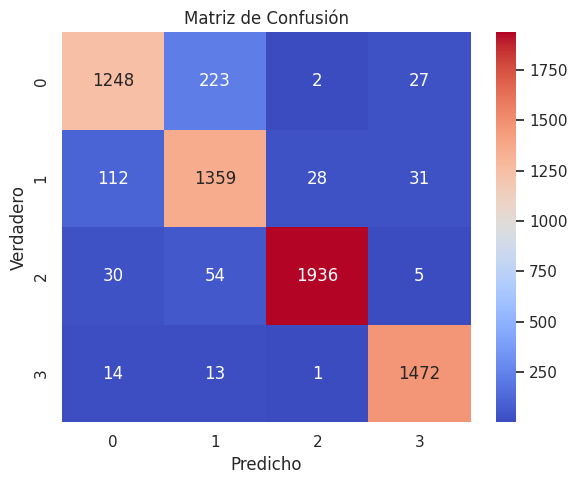

In [28]:
#Prediccion
y_pred_prob = modelo.predict(X_test_rotar) #Se obtiene predicciones en forma de probabilidad
y_pred = np.argmax(y_pred_prob, axis=1) #convertir probabilidades a clases
#Prueba
y_test_ = np.argmax(y_test_one, axis=1) #
#Reporte de clasificacion
reporte = classification_report(y_test_, y_pred)
#Matrix de confusion y curva roc
matrix = confusion_matrix(y_test_, y_pred)
# Calcular y mostrar ROC y AUC
fpr = {}
tpr = {}
roc_auc = {}

# Calcular la curva ROC para cada clase
for i in range(4):  # Cambia 4 por el número de clases en tu caso
    fpr[i], tpr[i], _ = roc_curve(y_test_ == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Calcular curva Precision-Recall y Average Precision (AP)
precision = {}
recall = {}
avg_precision = {}
for e in range(4):  # Cambia 4 por el número de clases
    precision[e], recall[e], _ = precision_recall_curve(y_test_ == e, y_pred_prob[:, e])
    avg_precision[e] = average_precision_score(y_test_ == e, y_pred_prob[:, e])

#=========================================================================================
#VISUALIZAR RESULTADOS
#========================================================================================
print('METRICAS DE EVALUACION MODELO RNN:')
print('----------------------------------\n')
print('--Reporte de Clasificacion:--')
print(reporte)

#GRAFICOS
plt.figure(figsize=(6, 5), dpi=100)
#Grafico matriz de confusion
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt='d',)
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')

plt.savefig('clasificacion.png')
plt.tight_layout()
plt.show()

    - Se observa valores muy aceptables en el recall.
    - El modelo tiene excelente rendimiento en las clases 2 y 3
    - Existe una deficiencia regular en clase de nombre "0", teniendo el recall mas bajo 88%, el modelo lo confunde en su mayoria con la clase 1
    
 **Recomendacion**
 Enfocarse en mejorar la clase 0, se puede agregar mas imagenes de esta clase o aumentar rotacion de las mismas imagenes

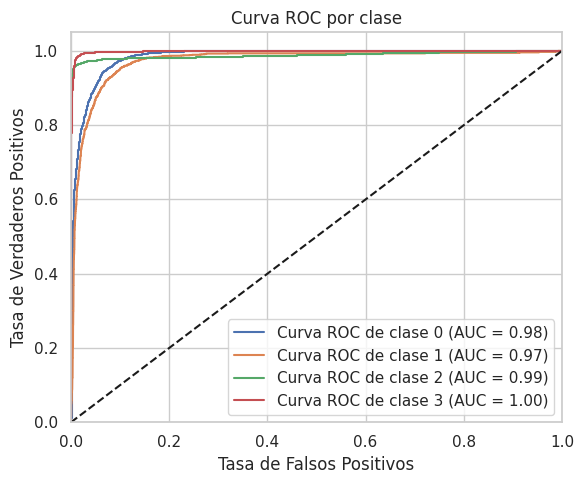

In [29]:
# Grafico curva ROC
plt.figure(figsize=(6, 5), dpi=100)
for i in range(4):
    plt.plot(fpr[i], tpr[i], label='Curva ROC de clase {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC por clase')
plt.legend(loc='lower right')

plt.savefig('curva_roc.png')
plt.tight_layout()
plt.show()

Resultados de las curvas ROC y areas bajo la curva(AUC) ayudan a detectar la importancia de verderos positivos.
El modelo es capaz de identificar correctamente las instancias de cada clase en un alto porcentaje de casos de otras clases

Es un excelente rendimiento en esta metrica pero no es la metrica central

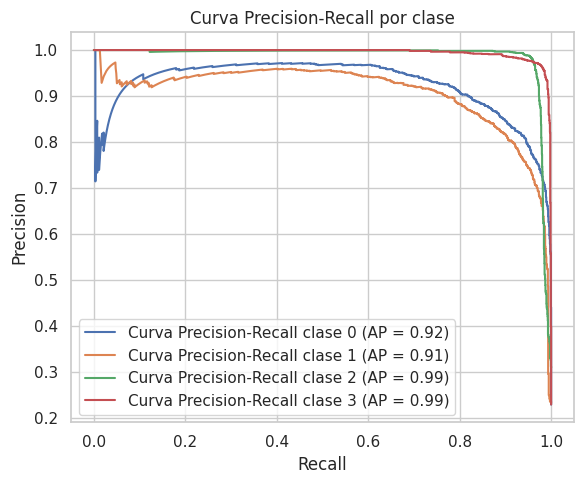

In [30]:
#Grafico curva de Precision-recall
plt.figure(figsize=(6, 5), dpi=100)
for e in range(4):
    plt.plot(recall[e], precision[e], label='Curva Precision-Recall clase {0} (AP = {1:0.2f})'.format(e, avg_precision[e]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall por clase')
plt.legend(loc='lower left')

plt.savefig('presicion_recall.png')
plt.tight_layout()
plt.show()

Se obserca resultados muy buenos, pero como se obsevo anteriormente, se necesita ligeramente mejorara la clase 0 y 1 

In [31]:
modelo.save('modelo_mri_tumor.h5')